In [1]:
import pandas as pd
from tqdm import tqdm
import os
import openai
import numpy as np
import pickle as pk
import seaborn as sns
import matplotlib.pyplot as plt
import json
keys = json.load(open("keys.json"))
os.environ["OPENAI_API_KEY"]=keys["OPENAI_API_KEY"]
openai.api_key = os.environ.get("OPENAI_API_KEY")
import together
os.environ["TOGETHER_API_KEY"]=keys["TOGETHER_API_KEY"]
together.api_key = os.environ.get("TOGETHER_API_KEY")
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [2]:
def together_call(prompt: str) -> str:
    """
    Calls TOGETHER API with input prompt.
    """
    output = together.Complete.create(
        prompt=prompt,
        model="meta-llama/Llama-3-70b-chat-hf",
        temperature=0,
        max_tokens=512,
        stop=[")", ")```"],
    )
    text_output = output["choices"][0]["text"].replace("assistant", "").replace("\n", "").replace("```", "")
    match = re.split(r"\)+", text_output, maxsplit=1)
    if match:
        return match[0]
    return text_output

def summarise_cluster(cluster_texts):
    text = ",".join(cluster_texts)
    # prompt = f"Summarise the sentences with a single theme phrase. Also output the mean similarity of the sentences on a scale of 1-5. Output format: (theme comma similarity) in round brackets (). Do not output any other words or text.\nSentences: [{text}]."
    prompt = f"Summarise the sentences with a single theme phrase. Output format: (theme). Do not output any other words or text.\nSentences: [{text}]."
    
    try:
        answer = together_call(prompt)
    except Exception as e:
        print("Error:", e)
        answer = "NA"
    # return str(len(cluster_texts)) + ", " + answer.replace("(", "")
    return answer.replace("(", "")

In [3]:
def gpt_call(prompt: str, model: str, temp: float) -> str:
    '''
    Calls OPENAI API with input and system prompt.
    '''
    response = openai.OpenAI().chat.completions.create(
        model = model,
        temperature = temp,
        max_tokens = 512,
        stop = ["]", "].", "]\n", "],"],
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content

def get_features(texts, task):
    for text in tqdm(texts):
        if text in text_to_features[task]:
            continue
        
        if task == "autbrick":
            prompt = f'''I have responses for alternate uses of a brick. 
        For the response {text}, give me and 0 (no) / 1 (yes) label for each of the following 130 features as a binary comma-separated list in square braces '[]':

        1. Can hold weight
        2. Provides elevation
        3. Used for construction
        4. Serves as a tool
        5. Used for organization
        6. Provides insulation
        7. Used in outdoor environments
        8. Provides seating
        9. Decorative use
        10. Involves stacking
        11. Aids in cooking
        12. Works as an anchor
        13. For crafting/art
        14. Offers protection/security
        15. Used for grinding/crushing
        16. Functions as a toy/game
        17. Involves digging
        18. For holding objects
        19. Provides heat retention
        20. Adds balance/stability
        21. Garden/landscaping use
        22. Supports furniture
        23. Used as a weapon
        24. Holds or displays items
        25. Sports-related
        26. Simulates real-world items (like food)
        27. Serves as a fence/barrier
        28. DIY home improvement
        29. Functions as a paperweight
        30. Used as a path or pavement
        31. Holds plants
        32. Provides traction
        33. Used as storage
        34. Supports cleaning
        35. Acts as a boundary
        36. Can be customized/painted
        37. Emulates animal toys/enrichment
        38. Cooking utensil function
        39. Makes sound (percussion)
        40. Used in fitness/weight training
        41. Marks boundaries or areas
        42. Provides seating/elevation for small tasks
        43. Indoor use
        44. Outdoor use
        45. Heat resistance
        46. Functions in protection
        47. Provides structural support
        48. Absorbs or transfers heat
        49. Used as art canvas
        50. Child-friendly toy
        51. Used as a foundation
        52. Can be glued or stuck together
        53. Holds liquids
        54. Used in teaching/education
        55. Historical/cultural significance
        56. Provides warmth
        57. Decorative lighting/illumination
        58. Fire resistance
        59. Functions as a miniature model
        60. Used in construction training
        61. Used for meditation or spiritual purposes
        62. Provides ground preparation for surfaces
        63. Temporary usage only
        64. Lightweight action
        65. Can be hollowed out or carved
        66. Can be heated or frozen
        67. Involves fine detail work (carving, engraving)
        68. Used for water retention/conservation
        69. For animal shelter/enrichment
        70. Functions as a weight/resistance tool
        71. Symbolic purpose (e.g., memorial)
        72. Mold for other materials
        73. Holds or organizes paper/documents
        74. Marks location or property
        75. Provides traction in icy/slippery conditions
        76. Supports outdoor play or games
        77. Used in gardening/planting
        78. Food-related preparation use
        79. Fits together modularly
        80. Urban infrastructure element
        81. Used as a temporary stand
        82. Helps prevent movement
        83. Assists in cutting/slicing
        84. Can be a solid color or painted
        85. Used for creative DIY projects
        86. Repurposed from another use
        87. Related to home security
        88. Works as a sound buffer or amplifier
        89. Holds fragile objects in place
        90. Non-functional decorative purpose
        91. Has industrial uses (e.g., for machines)
        92. Mimics natural stones/rocks
        93. Provides resistance to wear or pressure
        94. Maintains or marks temperature
        95. Acts as a table stabilizer
        96. Helps keep items organized
        97. Compatible with glue or adhesives
        98. Can withstand pressure or impact
        99. Affects airflow or ventilation
        100. Can be set up or removed easily
        101. Heavy or dense
        102. Lightweight
        103. Rough surface
        104. Smooth surface
        105. Porous material
        106. Water-resistant
        107. Fireproof
        108. Heat-absorbing
        109. Conductive (e.g., heat or electricity)
        110. Brittle or prone to shattering
        111. Durable/hard-wearing
        112. Flexible (can be shaped/molded)
        113. Sharp edges
        114. Rounded edges
        115. High friction surface (non-slip)
        116. Low friction surface (slippery)
        117. Resistant to erosion or weathering
        118. Reflective or shiny
        119. Opaque (does not allow light through)
        120. Translucent (allows some light through)
        121. Breakable into smaller pieces
        122. Contains color naturally (e.g., reddish-brown for clay bricks)
        123. Susceptible to cracking under pressure
        124. Absorbs moisture
        125. Non-magnetic
        126. Resists compression
        127. Can be compacted or layered
        128. Reactive to chemicals (e.g., lime in cement reacts with water)
        129. High thermal mass (retains temperature for long periods)
        130. Tends to expand or contract with temperature changes'''
        elif task == "autpaperclip":
            prompt = f'''I have responses for alternate uses of a paperclip. 
            For the response {text}, give me and 0 (no) / 1 (yes) label for each of the following 130 features as a binary comma-separated list in square braces '[]':

            1. Acts as a Holder
            2. Used in Crafting
            3. For Decoration
            4. Organizational Tool
            5. For Jewelry Making
            6. Emergency Tool
            7. Hair Accessories
            8. Cleaning Tool
            9. Makeshift Key
            10. Electrical Conductor
            11. Can Be Bent
            12. Temporary Repair
            13. Fashion Accessory
            14. For Paper Binding
            15. Medical Use
            16. Unclogging Tool
            17. Tool for Marking
            18. Household Tool
            19. Cooking Aid
            20. Experimental Tool
            21. Writing Aid
            22. Educational Use
            23. Hanging or Mounting
            24. Game or Toy
            25. Practical Art
            26. Clothes Fastening
            27. Home Decor
            28. Stress Relief
            29. Plant Support
            30. Signaling Device
            31. Key Management
            32. Tool for Threading
            33. Used in Repair
            34. Flexible Material
            35. Portable Size
            36. Utilizes Magnetic Properties
            37. Camping Gear
            38. Simple Machine Element
            39. Can Be Sharpened
            40. Battery Holder
            41. Craft Embellishment
            42. Medical Instrument
            43. Fixing Tools
            44. Engages in Symbolism
            45. Instrument for Piercing
            46. Microwave Safe
            47. For Binding Documents
            48. For Labeling
            49. Capable of Locking
            50. Can Be Combined with Other Tools
            51. Functions as a Marker
            52. Utilized in Outdoor Activities
            53. Can Conduct Heat
            54. Organizing Tool for Cables
            55. Stringing Capability
            56. Can Open Small Objects
            57. Home Repair Utility
            58. Reusability
            59. Holds Shape Under Pressure
            60. Packaging Utility
            61. Decoration for Holidays
            62. Aids in Food Preservation
            63. Mechanical Use
            64. Unsticking Small Items
            65. Suitable for Detangling
            66. Can Hold a Magnetic Charge
            67. Scales Down for Miniature Models
            68. Works as a Fastener
            69. Acts as a Divider
            70. Fine Motor Tool
            71. Works for Beadwork
            72. Aids in Safety
            73. Serves as a Scraper
            74. Appealing to Kids
            75. Connects Objects
            76. Can Be Painted
            77. Useful in Electronics
            78. Suitable for Weight Bearing
            79. Utilized in Sculpture
            80. Nonpermanent Tool
            81. Helpful for Packing
            82. Pin-like Functionality
            83. Can Be Decorated
            84. Adaptable Shape
            85. Clothesline Clip
            86. Aesthetic Enhancer
            87. Includes a Loop
            88. Can Function as a Wedge
            89. Helps in Counting
            90. Secure Closure
            91. Eyelet Creation
            92. Helps with Insertion
            93. Functions as a Lever
            94. For Bag Organization
            95. Suitable for Knotting
            96. Used for Pinning
            97. Simple Adhesive Substitute
            98. Building Material
            99. Good for Sorting
            100. Acts as an Engraving Tool
            101. Corrosion-Resistant
            102. Flexible Ends
            103. Non-toxic Coating
            104. High Reflectivity
            105. Low Reflectivity
            106. Colorful
            107. Transparent
            108. Opaque
            109. High Friction
            110. Non-flammable
            111. Scratch-Resistant
            112. Break-Resistant
            113. UV-Resistant
            114. Hypoallergenic
            115. Non-reactive
            116. Eco-Friendly Material
            117. Compact Shape
            118. Elasticity
            119. Sharp Ends
            120. Rounded Points
            121. Springy
            122. Lightweight
            123. Rust-Prone
            124. Sturdy Core
            125. Polished Finish
            126. Textile Friendly
            127. Dual-Layer Coating
            128. Minimal Deformation
            129. Smooth surface
            130. Ductile'''
        elif task == "vf":
            prompt = f'''For the animal {text}, give me and 0 (no) / 1 (yes) label for each of the following 130 features as a binary comma-separated list in square braces '[]':

            1. Is mammal
            2. Is bird
            3. Is insect
            4. Is reptile
            5. Is amphibian
            6. Is fish
            7. Is carnivore
            8. Is herbivore
            9. Is omnivore
            10. Has fur
            11. Has feathers
            12. Has scales
            13. Has exoskeleton
            14. Has beak
            15. Has claws
            16. Has whiskers
            17. Has horns
            18. Has antlers
            19. Has tusks
            20. Has wings
            21. Has tail
            22. Can fly
            23. Can swim
            24. Can climb
            25. Can dig
            26. Can jump
            27. Is nocturnal
            28. Is diurnal
            29. Has more than four limbs
            30. Lives in water
            31. Lives in trees
            32. Lives underground
            33. Lives on land
            34. Lays eggs
            35. Gives birth
            36. Has scales
            37. Has a long neck
            38. Is venomous
            39. Is domesticated
            40. Lives in groups
            41. Is solitary
            42. Builds nests
            43. Is migratory
            44. Has social hierarchy
            45. Uses tools
            46. Shows intelligence
            47. Communicates vocally
            48. Has camouflage
            49. Has stripes
            50. Has spots
            51. Can change color
            52. Is endangered
            53. Is commonly kept as a pet
            54. Is used in farming
            55. Is hunted by humans
            56. Is used for food by humans
            57. Is found in zoos
            58. Is capable of mimicry
            59. Has echolocation
            60. Is warm-blooded
            61. Is cold-blooded
            62. Has a long lifespan
            63. Is capable of regrowth
            64. Has specialized hunting techniques
            65. Is known for speed
            66. Is known for strength
            67. Has a specialized diet
            68. Is migratory
            69. Can hibernate
            70. Has a backbone
            71. Is marsupial
            72. Is placental
            73. Is monotreme
            74. Is flightless
            75. Has webbed feet
            76. Is known for intelligence
            77. Is a scavenger
            78. Is territorial
            79. Is native to Africa
            80. Is native to Asia
            81. Is native to North America
            82. Is native to South America
            83. Is native to Australia
            84. Is native to Europe
            85. Is found in deserts
            86. Is found in forests
            87. Is found in oceans
            88. Is found in grasslands
            89. Is found in mountains
            90. Has a mane
            91. Has a crest
            92. Has gills
            93. Is bioluminescent
            94. Is used in scientific research
            95. Is a predator
            96. Is prey for larger animals
            97. Is capable of parental care
            98. Lives in a burrow
            99. Is a pollinator
            100. Can tolerate extreme temperatures
            101. Exhibits seasonal color changes
            102. Migrates seasonally
            103. Is active during dawn or dusk (crepuscular)
            104. Produces pheromones for communication
            105. Lives symbiotically with other species
            106. Is a parasite
            107. Is a host for parasites
            108. Is bi-parental (both parents care for offspring)
            109. Displays mating rituals
            110. Has specialized courtship behavior
            111. Exhibits territorial marking
            112. Is associated with mythology or folklore
            113. Is endangered
            114. Exhibits altruistic behavior
            115. Is a keystone species in its ecosystem
            116. Uses burrows or dens for shelter
            117. Can regenerate body parts
            118. Is raised in captivity or farms
            119. Has unique reproductive strategies (e.g., asexual reproduction)
            120. Hibernates during winter
            121. Has a role in biological pest control
            122. Has distinct seasonal breeding cycles
            123. Forms a symbiotic relationship with plants (e.g., pollination)
            124. Uses specific vocalizations to communicate
            125. Is a flagship species (conservation symbol)
            126. Can be trained or tamed by humans
            127. Displays warning coloration
            128. Has flippers
            129. Has compound eyes
            130. Has a segmented body'''
        
        cnt = 0
        while True:
            try:
                response = gpt_call(prompt, "gpt-4o", 0)
            except Exception as e:
                print("Error:", e)
                response = 'NA'
        
            response = response[response.find("[") + 1:]
            print(text, response.count(","))
            print(response)
            cnt += 1
            if response.count(",") == 129 or cnt == 3:
                break

        text_to_features[task][text] = response

In [4]:
data = pd.read_csv("../csvs/data_humans_allresponses.csv")

data_autbrick = data[data["task"] == 2].reset_index(drop=True)
data_autpaperclip = data[data["task"] == 3].reset_index(drop=True)
data_vf = data[data["task"] == 1].reset_index(drop=True)

texts_autbrick = data_autbrick["response"].unique().tolist()
texts_autpaperclip = data_autpaperclip["response"].unique().tolist()
texts_vf = data_vf["response"].unique().tolist()

In [5]:
animal_features = pk.load(open("animal_features.pk", "rb"))
df = pd.DataFrame.from_dict(animal_features, orient='index')
animals_to_remove = ["dog cat monkey rat mouse hamster crocodile lion zebra giraffe elephant beaver hare rabbit parrot heron duck", "cow bull chicken dog cat shepherd", "cat dog lion tiger parrot monkey human food cows milk eggs hamster", "monkey dog cat guinea pig rabbit horsecow duck goat chicken elephant giraffe meerkat", " store", "tit", "python", "mammal", "le", "okay"]
df = df.loc[~df.index.isin(animals_to_remove)]
df = df.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})
df = df[df.applymap(lambda x: isinstance(x, int)).all(axis=1)]

/tmp/ipykernel_1820637/2413028618.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})
/tmp/ipykernel_1820637/2413028618.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df[df.applymap(lambda x: isinstance(x, int)).all(axis=1)]


In [6]:
df

feature_Is mammal  feature_Is bird  feature_Is insect  \
dog                                  1                0                  0   
cat                                  1                0                  0   
zebra                                1                0                  0   
giraffe                              1                0                  0   
seal                                 1                0                  0   
lion                                 1                0                  0   
tiger                                1                0                  0   
pigeon                               0                1                  0   
llama                                1                0                  0   
parrot                               0                1                  0   
puma                                 1                0                  0   
vulture                              0                1                  0   
guinea pig                           1                0                  0   
rabbit                               1                0                  0   
shark                                0                0                  0   
ant                                  0                0                  1   
beetle                               0                0                  1   
cockroach                            0                0                  1   
rat                                  1                0                  0   
mouse                                1                0                  0   
goldfish                             0                0                  0   
leopard                              1                0                  0   
spider                               0                0                  0   
lizard                               0                0                  0   
horse                                1                0                  0   
donkey                               1                0                  0   
bird                                 0                1                  0   
snail                                0                0                  0   
elephant                             1                0                  0   
meerkat                              1                0                  0   
fish                                 0                0                  0   
mosquito                             0                0                  1   
chicken                              0                1                  0   
cow                                  1                0                  0   
pig                                  1                0                  0   
sheep                                1                0                  0   
goat                                 1                0                  0   
hamster                              1                0                  0   
gecko                                0                0                  0   
snake                                0                0                  0   
crocodile                            0                0                  0   
parakeet                             0                1                  0   
magpie                               0                1                  0   
seagull                              0                1                  0   
ray                                  1                1                  0   
squid                                0                0                  0   
bat                                  1                0                  0   
koala                                1                0                  0   
panda                                1                0                  0   
cheetah                              1                0                  0   
owl                                  0     

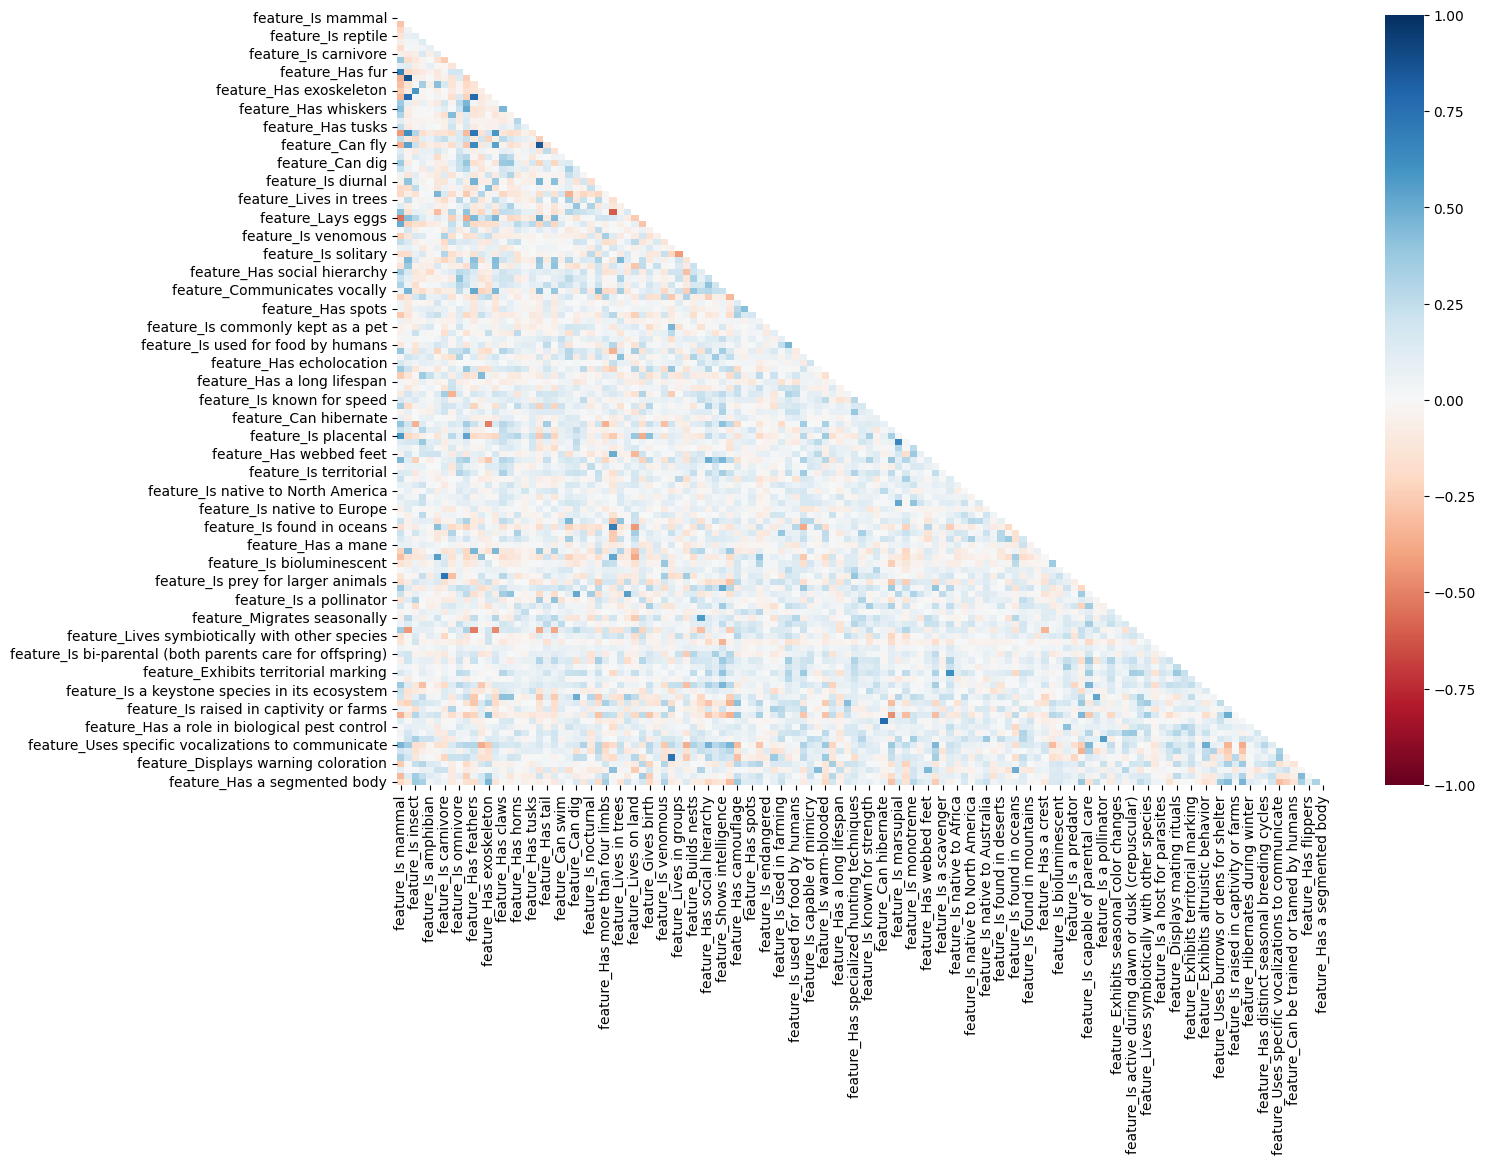

In [7]:
correlation_matrix = df.corr()
mask = np.triu(np.ones(correlation_matrix.shape), k=1)  # Upper triangle mask
corr = correlation_matrix.where(mask == 0)
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=False, cmap='RdBu', fmt=".1f", mask=np.triu(np.ones_like(corr, dtype=bool)), vmin=-1, vmax=1)
plt.show()

In [8]:
np.mean(corr.values > 0.5)

np.float64(0.00992001984003968)

In [9]:
mapped_features = data_vf['response'].map(animal_features)
mapped_features = mapped_features.apply(lambda x: x if isinstance(x, dict) else {})
fc = pd.DataFrame(mapped_features.tolist())
data_vf = pd.concat([data_vf, fc], axis=1)
data_vf = data_vf.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})

/tmp/ipykernel_1820637/3900814183.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_vf = data_vf.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})


In [10]:
feature_columns = [col for col in data_vf.columns if col.startswith('feature_')]
for col in feature_columns:
    data_vf[col] = pd.to_numeric(data_vf[col], errors='coerce')
data_vf = data_vf.dropna(subset=feature_columns)
feature_means = data_vf[feature_columns].mean(axis=0)
print(feature_means)

feature_Is mammal                                                          0.632362
feature_Is bird                                                            0.142495
feature_Is insect                                                          0.075206
feature_Is reptile                                                         0.055731
feature_Is amphibian                                                       0.012983
feature_Is fish                                                            0.065706
feature_Is carnivore                                                       0.329006
feature_Is herbivore                                                       0.271058
feature_Is omnivore                                                        0.367321
feature_Has fur                                                            0.388062
feature_Has feathers                                                       0.137587
feature_Has scales                                                         0

In [14]:
def find_consecutive_ones(df, feature_col):
    # result = {}
    counts = {}
    for subject in df["pid"].unique():
        subject_data = df[df["pid"] == subject][feature_col].values
        # counts = {}
        current_count = 0
        for value in subject_data:
            if value == 1:
                current_count += 1
            elif current_count > 0:
                counts[current_count] = counts.get(current_count, 0) + 1
                current_count = 0
        # Add the last streak if it ends with a 1
        if current_count > 0:
            counts[current_count] = counts.get(current_count, 0) + 1 
        # result[subject] = counts
    # return result
    return counts

feature_Is mammal 0.6323622545915136


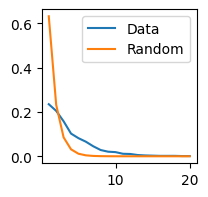

feature_Is bird 0.14249525015832806


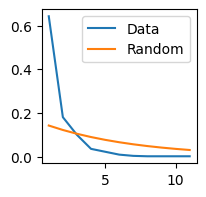

feature_Is insect 0.07520582647245092


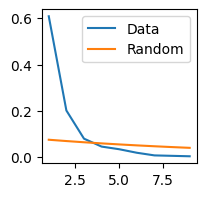

feature_Is reptile 0.05573147561747942


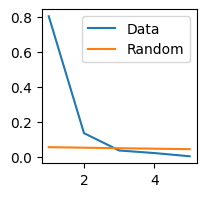

feature_Is amphibian 0.012982900569981


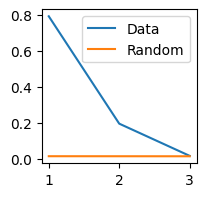

feature_Is fish 0.06570614312856238


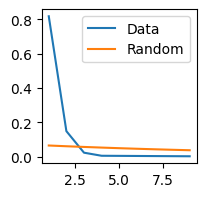

feature_Is carnivore 0.3290056998100063


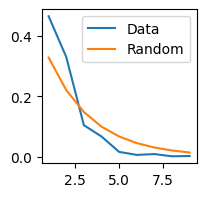

feature_Is herbivore 0.2710576314122863


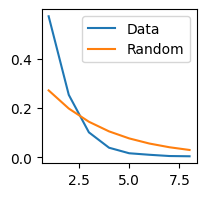

feature_Is omnivore 0.36732108929702345


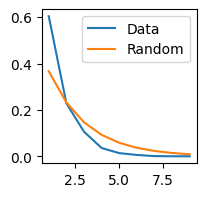

feature_Has fur 0.38806206459784676


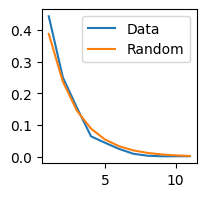

feature_Has feathers 0.13758708043065232


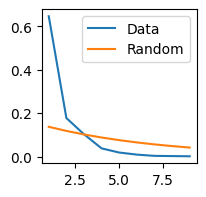

feature_Has scales 0.10734642178594046


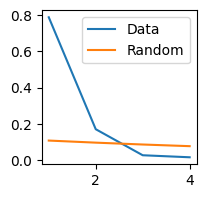

feature_Has exoskeleton 0.07583913869537683


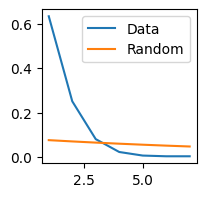

feature_Has beak 0.14708676377454086


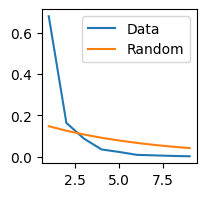

feature_Has claws 0.3655794806839772


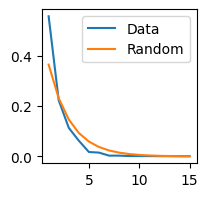

feature_Has whiskers 0.17384420519316024


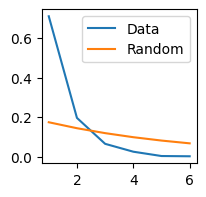

feature_Has horns 0.10069664344521849


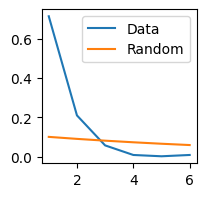

feature_Has antlers 0.011241291956934768


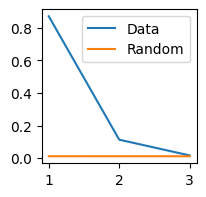

feature_Has tusks 0.08201393286890438


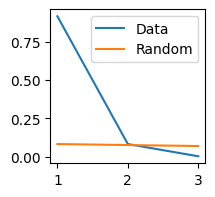

feature_Has wings 0.18492716909436352


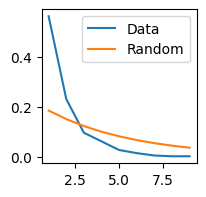

feature_Has tail 0.6418619379354021


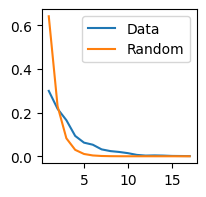

feature_Can fly 0.13362887903736542


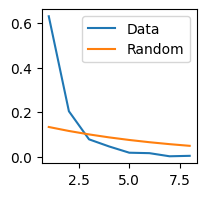

feature_Can swim 0.8239392020265991


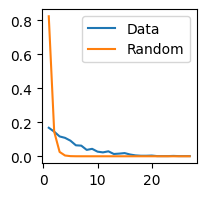

feature_Can climb 0.3655794806839772


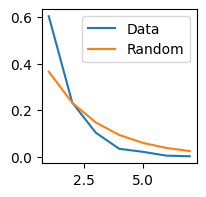

feature_Can dig 0.3088980367321089


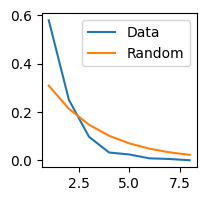

feature_Can jump 0.3448385053831539


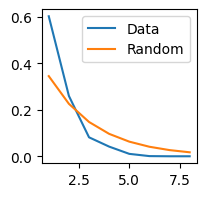

feature_Is nocturnal 0.13932868904369855


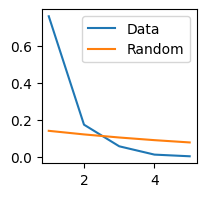

feature_Is diurnal 0.35512982900569984


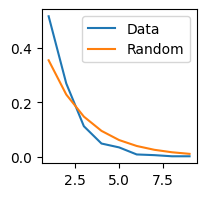

feature_Has more than four limbs 0.12935402153261558


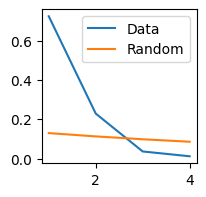

feature_Lives in water 0.17368587713742875


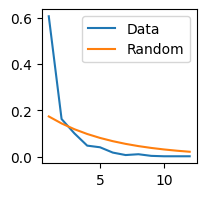

feature_Lives in trees 0.09626345788473717


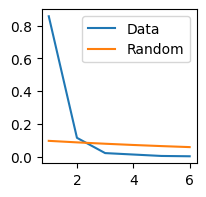

feature_Lives underground 0.06776440785307157


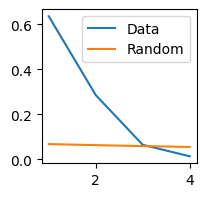

feature_Lives on land 0.7232425585813806


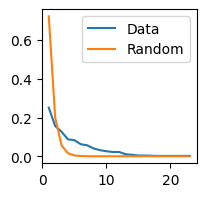

feature_Lays eggs 0.2930652311589614


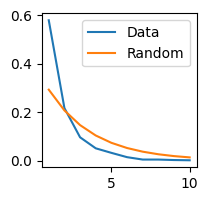

feature_Gives birth 0.2811906269791007


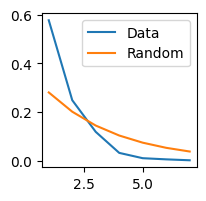

feature_Has a long neck 0.09927169094363521


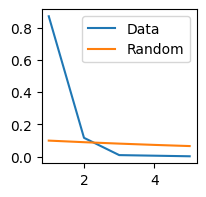

feature_Is venomous 0.07552248258391386


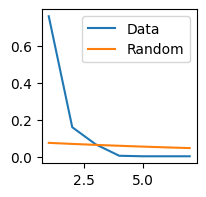

feature_Is domesticated 0.3280557314756175


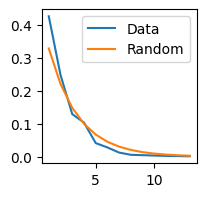

feature_Lives in groups 0.3239392020265991


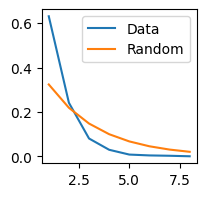

feature_Is solitary 0.32615579480683976


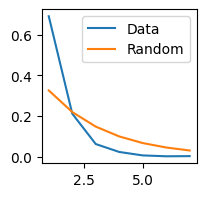

feature_Builds nests 0.25158328055731477


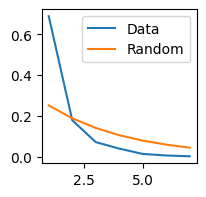

feature_Is migratory 0.15500316656111462


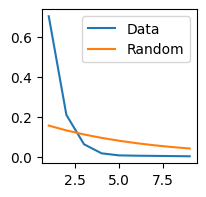

feature_Has social hierarchy 0.8932868904369854


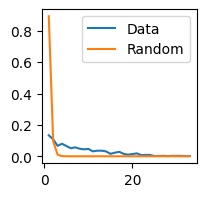

feature_Uses tools 0.20756808106396454


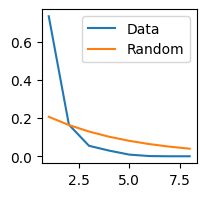

feature_Shows intelligence 0.9659594680177327


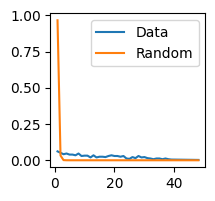

feature_Communicates vocally 0.33613046231792276


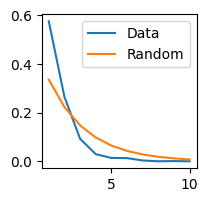

feature_Has camouflage 0.26789107029765674


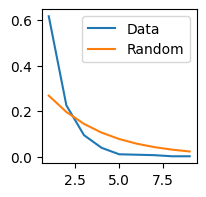

feature_Has stripes 0.08359721342621912


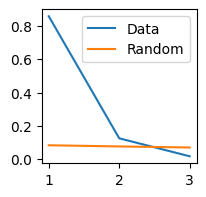

feature_Has spots 0.12397086763774541


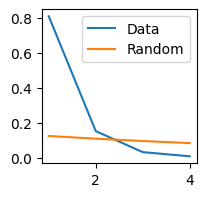

feature_Can change color 0.08454718176060798


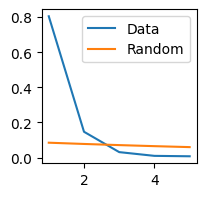

feature_Is endangered 0.006333122229259025


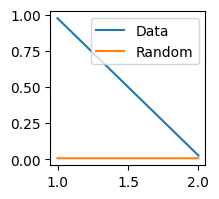

feature_Is commonly kept as a pet 0.3624129195693477


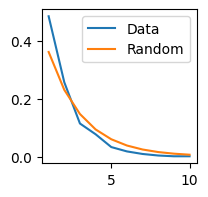

feature_Is used in farming 0.3247308423052565


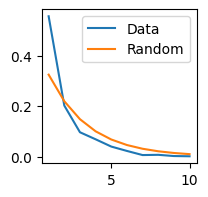

feature_Is hunted by humans 0.7352754908169727


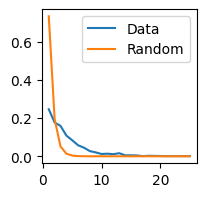

feature_Is used for food by humans 0.5145661811272958


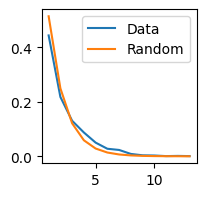

feature_Is found in zoos 0.8267891070297657


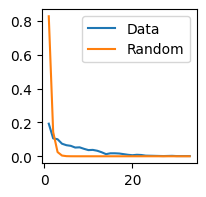

feature_Is capable of mimicry 0.13822039265357822


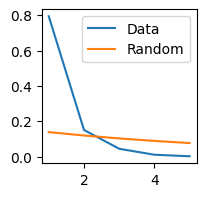

feature_Has echolocation 0.033407219759341356


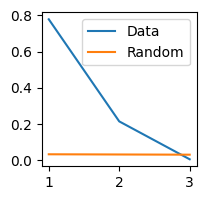

feature_Is warm-blooded 0.3513299556681444


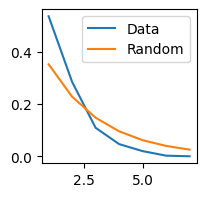

feature_Is cold-blooded 0.08597213426219126


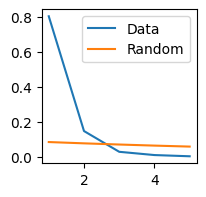

feature_Has a long lifespan 0.11573780873970868


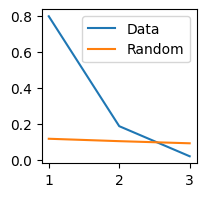

feature_Is capable of regrowth 0.4756174794173528


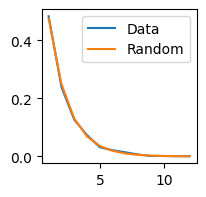

feature_Has specialized hunting techniques 0.7224509183027232


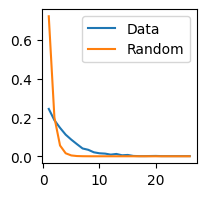

feature_Is known for speed 0.2416086130462318


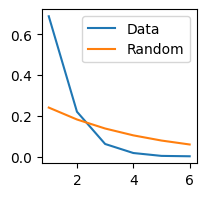

feature_Is known for strength 0.5471817606079797


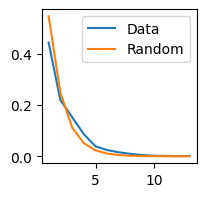

feature_Has a specialized diet 0.8755541481950602


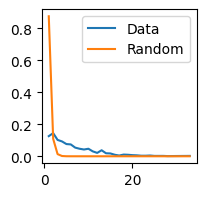

feature_Can hibernate 0.01551614946168461


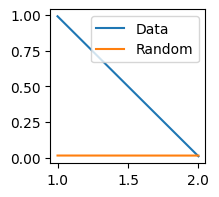

feature_Has a backbone 0.8546548448385054


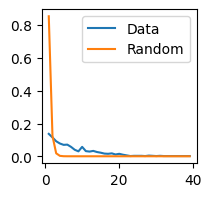

feature_Is marsupial 0.02200759974667511


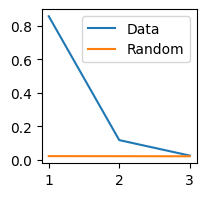

feature_Is placental 0.38236225459151363


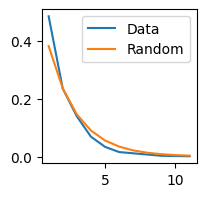

feature_Is monotreme 0.007283090563647878


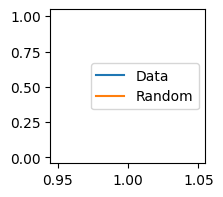

feature_Is flightless 0.1949018366054465


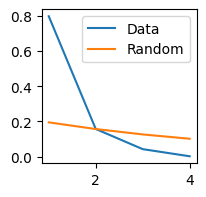

feature_Has webbed feet 0.1363204559848005


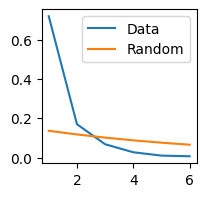

feature_Is known for intelligence 0.8153894870170995


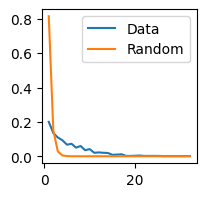

feature_Is a scavenger 0.05145661811272958


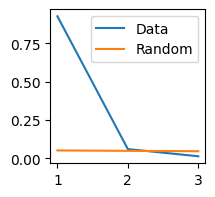

feature_Is territorial 0.7587080430652312


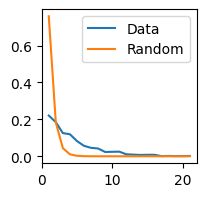

feature_Is native to Africa 0.16244458518049398


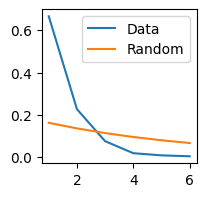

feature_Is native to Asia 0.23226725775807472


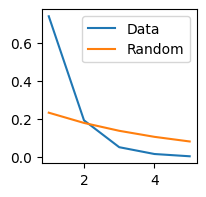

feature_Is native to North America 0.09056364787840405


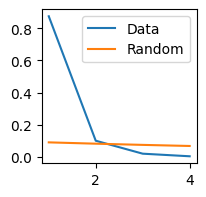

feature_Is native to South America 0.03974034198860038


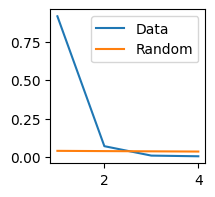

feature_Is native to Australia 0.05446485117162761


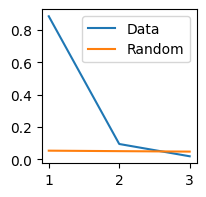

feature_Is native to Europe 0.07298923369221026


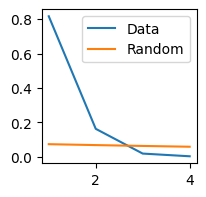

feature_Is found in deserts 0.06918936035465484


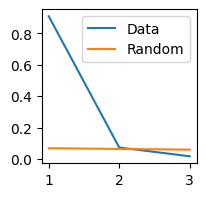

feature_Is found in forests 0.24525015832805575


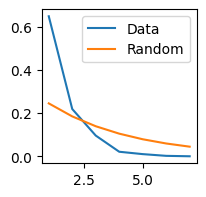

feature_Is found in oceans 0.14597846738442052


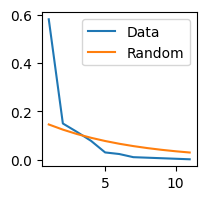

feature_Is found in grasslands 0.37191260291323625


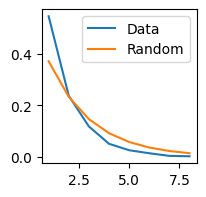

feature_Is found in mountains 0.15737808739708675


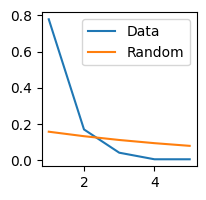

feature_Has a mane 0.05636478784040532


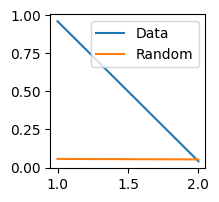

feature_Has a crest 0.10734642178594046


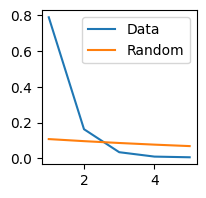

feature_Has gills 0.061272957568081064


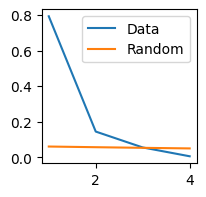

feature_Is bioluminescent 0.030398986700443317


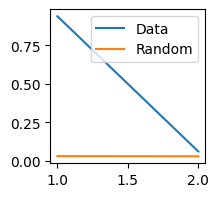

feature_Is used in scientific research 0.9859088030398987


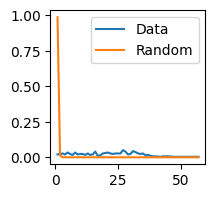

feature_Is a predator 0.34515516149461684


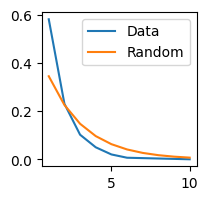

feature_Is prey for larger animals 0.35671310956301455


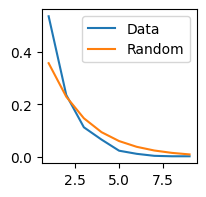

feature_Is capable of parental care 0.8703293223559214


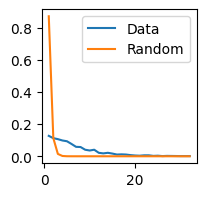

feature_Lives in a burrow 0.12935402153261558


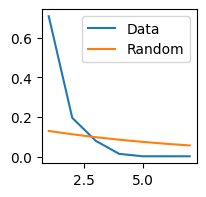

feature_Is a pollinator 0.037682077264091195


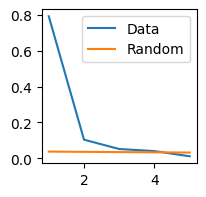

feature_Can tolerate extreme temperatures 0.55794806839772


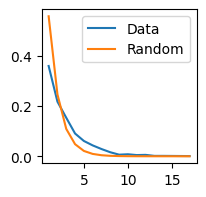

feature_Exhibits seasonal color changes 0.02026599113362888


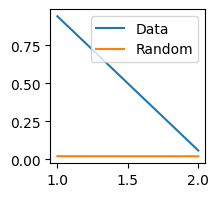

feature_Migrates seasonally 0.353863204559848


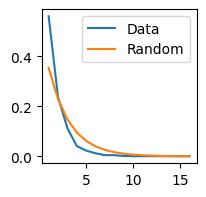

feature_Is active during dawn or dusk (crepuscular) 0.49952501583280556


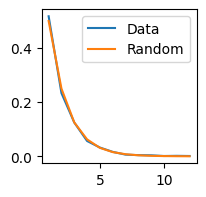

feature_Produces pheromones for communication 0.808581380620646


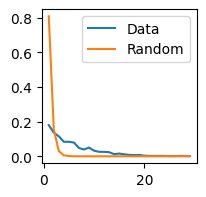

feature_Lives symbiotically with other species 0.6445535148828372


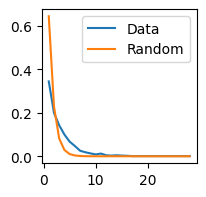

feature_Is a parasite 0.007599746675110829


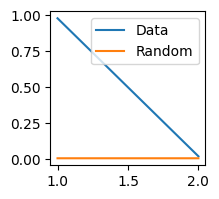

feature_Is a host for parasites 0.9976250791640279


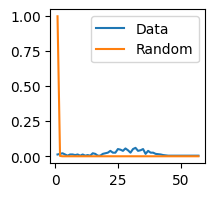

feature_Is bi-parental (both parents care for offspring) 0.19331855604813172


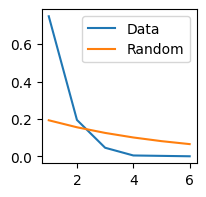

feature_Displays mating rituals 0.7579164027865738


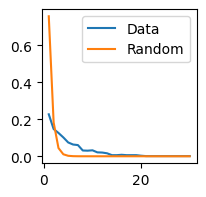

feature_Has specialized courtship behavior 0.9868587713742876


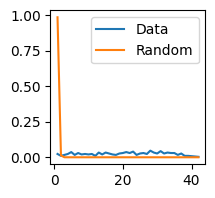

feature_Exhibits territorial marking 0.7984483850538315


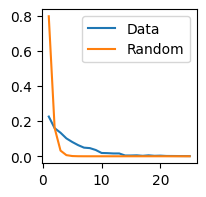

feature_Is associated with mythology or folklore 0.9925585813806207


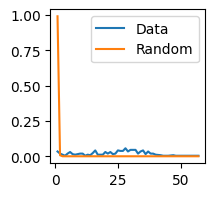

feature_Exhibits altruistic behavior 0.8461051298290057


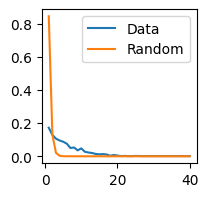

feature_Is a keystone species in its ecosystem 0.19236858771374288


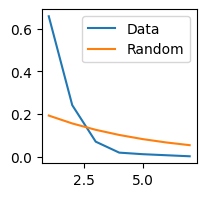

feature_Uses burrows or dens for shelter 0.3163394553514883


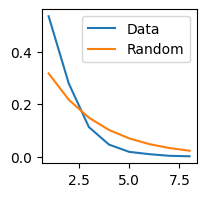

feature_Can regenerate body parts 0.41386953768207724


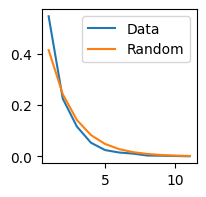

feature_Is raised in captivity or farms 0.6249208359721342


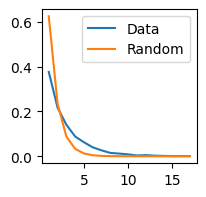

feature_Has unique reproductive strategies (e.g., asexual reproduction) 0.24715009499683344


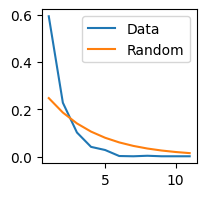

feature_Hibernates during winter 0.013616212792906902


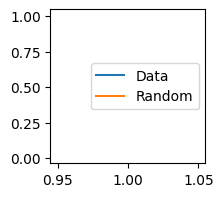

feature_Has a role in biological pest control 0.9662761241291957


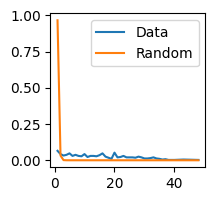

feature_Has distinct seasonal breeding cycles 0.3486383787207093


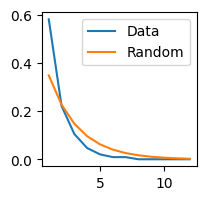

feature_Forms a symbiotic relationship with plants (e.g., pollination) 0.035148828372387586


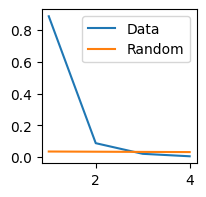

feature_Uses specific vocalizations to communicate 0.7607663077897403


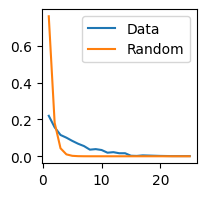

feature_Is a flagship species (conservation symbol) 0.5473400886637112


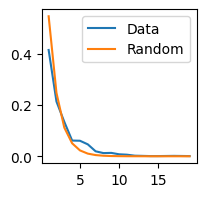

feature_Can be trained or tamed by humans 0.47324255858138065


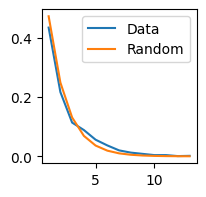

feature_Displays warning coloration 0.26535782140595315


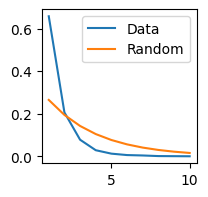

feature_Has flippers 0.08628879037365421


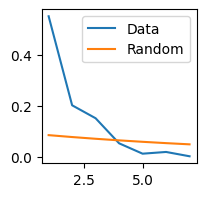

feature_Has compound eyes 0.2891070297656745


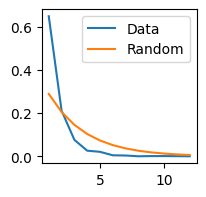

feature_Has a segmented body 0.11763774540848639


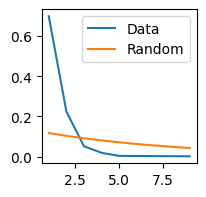

In [41]:
# from scipy.integrate import simps
for col in feature_columns:
    plt.figure(figsize = (2,2))
    p = feature_means.loc[col]
    print(col, p)
    fco = dict(sorted(find_consecutive_ones(data_vf, col).items()))
    plt.plot(list(fco.keys()), np.array(list(fco.values())) / (np.sum(list(fco.values()))), label = "Data")
    x = np.arange(1, list(fco.keys())[-1] + 1)
    geometric_pdf = p * (1 - p) ** (x - 1)
    plt.plot(x, geometric_pdf, label = "Random")
    plt.legend()
    plt.show()
    # break


In [ ]:
plt.hist(feature_means.values);
plt.hist(df.mean(axis=0).values, alpha = 0.3);

In [17]:
persistence = {}
for f in feature_columns:
    persistence[f] = find_consecutive_ones(data_vf, f)

In [ ]:
persistence["feature_Can fly"]

In [4]:
text_to_features = {}
text_to_features["autbrick"] = {}
text_to_features["autpaperclip"] = {}
text_to_features["vf"] = {}

In [6]:
# get_features(texts_vf, "vf")
text_to_features["vf"] = pk.load(open("../pickle/text_to_features_vf.pk", "rb"))

In [7]:
vf_features = [
    "feature_Is mammal",
    "feature_Is bird",
    "feature_Is insect",
    "feature_Is reptile",
    "feature_Is amphibian",
    "feature_Is fish",
    "feature_Is carnivore",
    "feature_Is herbivore",
    "feature_Is omnivore",
    "feature_Has fur",
    "feature_Has feathers",
    "feature_Has scales",
    "feature_Has exoskeleton",
    "feature_Has beak",
    "feature_Has claws",
    "feature_Has whiskers",
    "feature_Has horns",
    "feature_Has antlers",
    "feature_Has tusks",
    "feature_Has wings",
    "feature_Has tail",
    "feature_Can fly",
    "feature_Can swim",
    "feature_Can climb",
    "feature_Can dig",
    "feature_Can jump",
    "feature_Is nocturnal",
    "feature_Is diurnal",
    "feature_Has more than four limbs",
    "feature_Lives in water",
    "feature_Lives in trees",
    "feature_Lives underground",
    "feature_Lives on land",
    "feature_Lays eggs",
    "feature_Gives birth",
    "feature_Has scales",
    "feature_Has a long neck",
    "feature_Is venomous",
    "feature_Is domesticated",
    "feature_Lives in groups",
    "feature_Is solitary",
    "feature_Builds nests",
    "feature_Is migratory",
    "feature_Has social hierarchy",
    "feature_Uses tools",
    "feature_Shows intelligence",
    "feature_Communicates vocally",
    "feature_Has camouflage",
    "feature_Has stripes",
    "feature_Has spots",
    "feature_Can change color",
    "feature_Is endangered",
    "feature_Is commonly kept as a pet",
    "feature_Is used in farming",
    "feature_Is hunted by humans",
    "feature_Is used for food by humans",
    "feature_Is found in zoos",
    "feature_Is capable of mimicry",
    "feature_Has echolocation",
    "feature_Is warm-blooded",
    "feature_Is cold-blooded",
    "feature_Has a long lifespan",
    "feature_Is capable of regrowth",
    "feature_Has specialized hunting techniques",
    "feature_Is known for speed",
    "feature_Is known for strength",
    "feature_Has a specialized diet",
    "feature_Is migratory",
    "feature_Can hibernate",
    "feature_Has a backbone",
    "feature_Is marsupial",
    "feature_Is placental",
    "feature_Is monotreme",
    "feature_Is flightless",
    "feature_Has webbed feet",
    "feature_Is known for intelligence",
    "feature_Is a scavenger",
    "feature_Is territorial",
    "feature_Is native to Africa",
    "feature_Is native to Asia",
    "feature_Is native to North America",
    "feature_Is native to South America",
    "feature_Is native to Australia",
    "feature_Is native to Europe",
    "feature_Is found in deserts",
    "feature_Is found in forests",
    "feature_Is found in oceans",
    "feature_Is found in grasslands",
    "feature_Is found in mountains",
    "feature_Has a mane",
    "feature_Has a crest",
    "feature_Has gills",
    "feature_Is bioluminescent",
    "feature_Is used in scientific research",
    "feature_Is a predator",
    "feature_Is prey for larger animals",
    "feature_Is capable of parental care",
    "feature_Lives in a burrow",
    "feature_Is a pollinator",
    "feature_Can tolerate extreme temperatures",
    "feature_Exhibits seasonal color changes",
    "feature_Migrates seasonally",
    "feature_Is active during dawn or dusk (crepuscular)",
    "feature_Produces pheromones for communication",
    "feature_Lives symbiotically with other species",
    "feature_Is a parasite",
    "feature_Is a host for parasites",
    "feature_Is bi-parental (both parents care for offspring)",
    "feature_Displays mating rituals",
    "feature_Has specialized courtship behavior",
    "feature_Exhibits territorial marking",
    "feature_Is associated with mythology or folklore",
    "feature_Is endangered",
    "feature_Exhibits altruistic behavior",
    "feature_Is a keystone species in its ecosystem",
    "feature_Uses burrows or dens for shelter",
    "feature_Can regenerate body parts",
    "feature_Is raised in captivity or farms",
    "feature_Has unique reproductive strategies (e.g., asexual reproduction)",
    "feature_Hibernates during winter",
    "feature_Has a role in biological pest control",
    "feature_Has distinct seasonal breeding cycles",
    "feature_Forms a symbiotic relationship with plants (e.g., pollination)",
    "feature_Uses specific vocalizations to communicate",
    "feature_Is a flagship species (conservation symbol)",
    "feature_Can be trained or tamed by humans",
    "feature_Displays warning coloration",
    "feature_Has flippers",
    "feature_Has compound eyes",
    "feature_Has a segmented body"
]

In [8]:
for key in text_to_features["vf"]:
    text_to_features["vf"][key] = dict(zip(vf_features, [int(x.strip()) for x in text_to_features["vf"][key].split(',')]))

In [9]:
mapped_features = data_vf['response'].map(text_to_features["vf"])
mapped_features = mapped_features.apply(lambda x: x if isinstance(x, dict) else {})
feature_columns = pd.DataFrame(mapped_features.tolist())
data_vf = pd.concat([data_vf, feature_columns], axis=1)

In [ ]:
def compute_jump(group):
    group = group.copy()  # Avoid modifying the original DataFrame
    group['jump'] = np.nan
    group.iloc[0, group.columns.get_loc('jump')] = 1  # First jump in each group is always 1

    for i in range(1, len(group)):
        # Check for NaN values in either row
        if group.iloc[i - 1][vf_features].isnull().any() or group.iloc[i][vf_features].isnull().any():
            group.iloc[i, group.columns.get_loc('jump')] = np.nan        # if nan, for now consider jump
        else:
            # Check for consecutive 1s in any feature column
            consecutive_ones = (group.iloc[i - 1][vf_features] == 1) & (group.iloc[i][vf_features] == 1)
            if consecutive_ones.any():
                group.iloc[i, group.columns.get_loc('jump')] = 0
            else:
                group.iloc[i, group.columns.get_loc('jump')] = 1
    return group

data_vf['jump'] = None
data_vf = data_vf.groupby('pid', group_keys=False).apply(compute_jump)

In [ ]:
def calculate_num_features_same(group):
    group = group.reset_index(drop=True)
    num_features_same = [np.nan]  # Initialize with nan for the first row
    feature_cols = [col for col in group.columns if col.startswith('feature_')]
    
    # for i in range(1, len(group)):
    #     consecutive_1s = (group.loc[i - 1, feature_cols] == 1) & (group.loc[i, feature_cols] == 1)
    #     num_features_same.append(consecutive_1s.sum())
    for i in range(1, len(group)):
        row1 = group.loc[i - 1, feature_cols]
        row2 = group.loc[i, feature_cols]
        
        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same.append(np.nan)
        else:
            consecutive_1s = (row1 == 1) & (row2 == 1)
            num_features_same.append(consecutive_1s.sum())
    
    group['num_features_same'] = num_features_same
    return group

data_vf['num_features_same'] = None
data_vf = data_vf.groupby('pid', group_keys=False).apply(calculate_num_features_same)

In [12]:
data_vf = data_vf[(data_vf["order"] > 0) & (data_vf["order"] < 20)]

In [14]:
# data_vf["jump_profile"] = data_vf.groupby("pid")["jump"].cumsum()

In [ ]:
# data_vf["jump_profile"].value_counts()

In [14]:
data_humans = pd.read_csv("../csvs/data_humans.csv")

In [15]:
data_humans_vf = data_humans[data_humans["task"] == 1].drop("Unnamed: 0", axis=1)

In [23]:
data_vf_merged = pd.merge(data_vf, data_humans_vf, on=['pid', 'task', 'starttime', 'endtime', 'original_response_Dutch',
       'original_response', 'original_response_cleaned', 'response', 'invalid', 'response_len', 'response_num_words', 'previous_original_response', 'previous_response', 'order', 'RT'], how='outer')

In [ ]:
plt.scatter(data_vf_merged["SS"], data_vf_merged["num_features_same"])

In [ ]:
print(data_vf_merged[["response", "previous_response", "num_features_same", "SS", "jump_y"]][data_vf_merged["num_features_same"] < 10]["SS"].mean())
data_vf_merged[["response", "previous_response", "num_features_same", "SS", "jump_y"]][data_vf_merged["num_features_same"] < 10].drop_duplicates().head(50)

In [ ]:
print(data_vf_merged[["response", "previous_response", "num_features_same", "SS", "jump_y"]][data_vf_merged["num_features_same"] > 30]["SS"].mean())
data_vf_merged[["response", "previous_response", "num_features_same", "SS", "jump_y"]][data_vf_merged["num_features_same"] > 20].drop_duplicates().head(50)

In [ ]:
plt.hist(data_vf_merged["num_features_same"], bins=100);

In [ ]:
data_vf_merged[data_vf_merged["pid"] == 2657]

In [ ]:
plt.hist(data_vf_merged["SS"]);

In [ ]:
pd.merge(data_vf_merged[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_vf_merged[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")

In [ ]:
plt.scatter(np.arange(219), pd.merge(data_vf_merged[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_vf_merged[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"])

In [ ]:
plt.plot()

In [ ]:
# Few vs many dimensions
# How persistant are different dimensions? Compared to random
# How correlated are different dimensions? Can help decrease #dims
# Transitions between different dimensions? 